# Net Demand Forecast

This notebook reads in three forecasts and combines them into one to predict net demand. First is the total demand forecast from notebook 1C, second is the solar production forecast from notebook 3C, and third is the wind production forecast from notebook 4C. These are combined to forecast the net demand that must be filled by hydro and gas plants.

### Imports

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

### Read in predictions of demand, solar output, and wind output

In [87]:
demand = pd.read_csv('../datasets/demand_predictions.csv')
solar = pd.read_csv('../datasets/solar_prediction.csv')
wind = pd.read_csv('../datasets/wind_prediction.csv')

In [88]:
demand.rename(columns={'Unnamed: 0':'date','0':'demand'},inplace=True)
demand.tail(3)

,date,demand
165,2020-05-21 21:00:00,26427.913024
166,2020-05-21 22:00:00,24683.404685
167,2020-05-21 23:00:00,22923.274018


In [89]:
solar.tail(3)

,date,solar_prediction
161,2020-05-21 21:00:00,3.098171
162,2020-05-21 22:00:00,3.098171
163,2020-05-21 23:00:00,3.098171


In [90]:
wind.tail(3)

,date,wind_prediction
161,2020-05-21 21:00:00,1842.028590
162,2020-05-21 22:00:00,2040.498334
163,2020-05-21 23:00:00,2283.806863


### Merge predictions

In [92]:
predictions = demand.merge(solar,how='inner',on='date')
predictions = predictions.merge(wind,how='inner',on='date')
print(predictions.shape)
predictions.tail(3)

(164, 4)


,date,demand,solar_prediction,wind_prediction
161,2020-05-21 21:00:00,26427.913024,3.098171,1842.028590
162,2020-05-21 22:00:00,24683.404685,3.098171,2040.498334
163,2020-05-21 23:00:00,22923.274018,3.098171,2283.806863


### Calculate net demand forecast

In [93]:
predictions['solar_and_wind'] = predictions['solar_prediction']+predictions['wind_prediction']
predictions['net_demand_prediction'] = predictions['demand'] - predictions['solar_and_wind']
predictions['date'] = pd.to_datetime(predictions['date'])
predictions.set_index('date',inplace=True)
predictions.head(3)

,demand,solar_prediction,wind_prediction,solar_and_wind,net_demand_prediction
date,,,,,
2020-05-15 04:00:00,19726.376705,3.098171,3159.794258,3162.892428,16563.484277
2020-05-15 05:00:00,20429.428291,3.098171,3408.533372,3411.631543,17017.796748
2020-05-15 06:00:00,20986.243994,3.098171,3283.478098,3286.576269,17699.667725


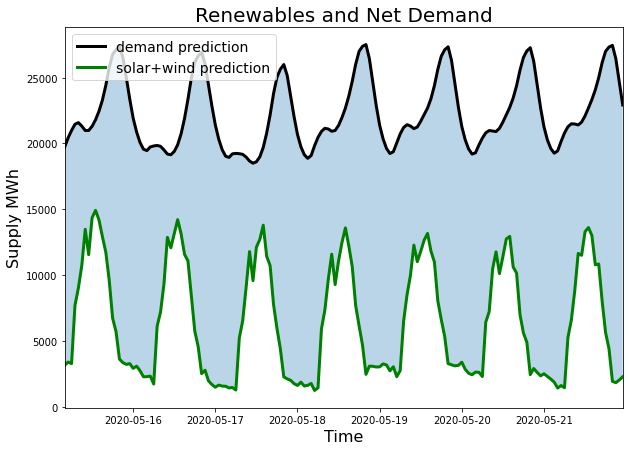

In [101]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(predictions.index,predictions['demand'],'k-',label='demand prediction',lw=3)
ax.plot(predictions.index,predictions['solar_and_wind'],'g-',label='solar+wind prediction',lw=3)
ax.fill_between(predictions.index,predictions['solar_and_wind'],predictions['demand'],alpha=0.3)
ax.legend(fontsize=14,loc='upper left')
plt.xlabel('Time',fontsize=16)
plt.ylabel('Supply MWh',fontsize=16)
plt.title('Renewables and Net Demand',fontsize=20)
plt.xlim((predictions.index[0],predictions.index[-1]));
#plt.savefig('../images/renewables_net_demand_prediction.png',dpi=235,bbox_inches='tight');

### Read in supply data to evaluate forecast

In [80]:
sup = pd.read_csv('../datasets/time_series/supply_series.csv')
sup['date'] = pd.to_datetime(sup['date'])
sup.set_index('date', inplace=True)
sup_hrly = sup.resample('H').mean()
print(sup_hrly.shape)
sup_hrly.head(3)

(18492, 5)


,gas,hydro,renewables,imports,total
date,,,,,
2018-04-12 00:00:00,5928.75,3046.000000,5940.333333,5525.083333,20440.166667
2018-04-12 01:00:00,5429.75,2690.333333,5762.000000,5913.666667,19795.750000
2018-04-12 02:00:00,5029.25,2702.250000,5772.750000,5854.500000,19358.750000


In [81]:
ren = pd.read_csv('../datasets/time_series/renewables_series.csv')
ren['date'] = pd.to_datetime(ren['date'])
ren.set_index('date', inplace=True)
ren_hrly = ren.resample('H').mean()
print(ren_hrly.shape)
ren_hrly.head(3)

(18504, 5)


,solar,wind,geothermal,biomass,biogas
date,,,,,
2018-04-12 00:00:00,0.0,4334.916667,688.250000,243.166667,241.333333
2018-04-12 01:00:00,0.0,4197.000000,654.750000,236.916667,241.083333
2018-04-12 02:00:00,0.0,4250.583333,643.916667,238.333333,242.500000


### Merge predictions with supply

In [104]:
predictions = predictions.merge(sup_hrly,how='inner',left_index=True,right_index=True)
predictions = predictions.merge(ren_hrly,how='inner',left_index=True,right_index=True)
predictions.head(3)

,demand,solar_prediction,wind_prediction,solar_and_wind,net_demand_prediction,gas,hydro,renewables,imports,total,solar,wind,geothermal,biomass,biogas
date,,,,,,,,,,,,,,,
2020-05-15 04:00:00,19726.376705,3.098171,3159.794258,3162.892428,16563.484277,2750.75,2228.833333,4946.333333,8824.000000,18749.916667,-35.666667,3256.166667,899.416667,308.666667,211.333333
2020-05-15 05:00:00,20429.428291,3.098171,3408.533372,3411.631543,17017.796748,2815.00,2468.833333,5023.916667,8986.583333,19294.333333,-32.916667,3322.000000,902.250000,309.500000,211.333333
2020-05-15 06:00:00,20986.243994,3.098171,3283.478098,3286.576269,17699.667725,2977.00,2600.083333,6095.416667,8152.750000,19825.250000,1160.166667,3209.666667,901.833333,313.833333,210.333333


### Calculate true net demand
- add hydro, gas, imports, and all renewables but solar and wind

In [105]:
predictions['net_demand_true'] = predictions['hydro']+predictions['gas']+predictions['imports']+predictions['geothermal']+predictions['biomass']+predictions['biogas']

### Evaluate prediction

RMSE = 3323.6600437697975


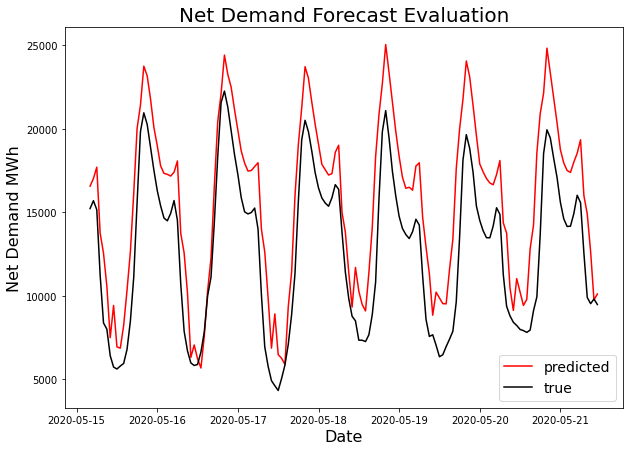

In [109]:
print(f"RMSE = {np.sqrt(mean_squared_error(predictions['net_demand_true'],predictions['net_demand_prediction']))}")
plt.figure(figsize=(10,7))
plt.plot(predictions.index,predictions['net_demand_prediction'],'r-',label='predicted')
plt.plot(predictions.index,predictions['net_demand_true'],'k-',label='true')
plt.legend(fontsize=14);
plt.xlabel('Date',fontsize=16)
plt.ylabel('Net Demand MWh',fontsize=16)
plt.title('Net Demand Forecast Evaluation',fontsize=20);
plt.savefig('../images/net_demand_forecast.png',dpi=235,bbox_inches='tight');

Text(0, 0.5, 'predicted net demand')

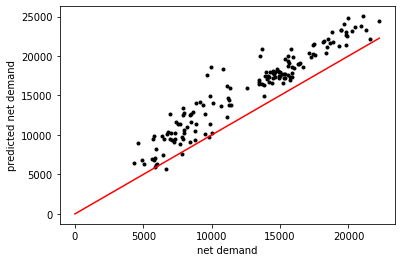

In [114]:
plt.plot(predictions['net_demand_true'],predictions['net_demand_prediction'],'k.')
plt.plot([0,max(predictions['net_demand_true'])],[0,max(predictions['net_demand_true'])],'r-')
plt.xlabel('net demand')
plt.ylabel('predicted net demand')